In [1]:
from utils import WindowGenerator
import numpy as np
import pandas as pd
import tensorflow as tf
import IPython
import matplotlib.pyplot as plt
import pickle

In [2]:
# Import data
features = ['NO1_consumption', 
            'NO1_temperature', 
            'time_of_day', 
            'time_of_week', 
            'time_of_year', 
            'NO1_consumption_lag_24', 
            'NO1_temperature_lag_24', 
            'NO1_consumption_mean_24', 
            'NO1_temperature_mean_24']

train_df = pd.read_csv('./data/train.csv')[features]
test_df = pd.read_csv('./data/test.csv')[features]
val_df = pd.read_csv('./data/val.csv')[features]

## WindowGenerator

In [3]:
# Create window generator
window = WindowGenerator(   input_width=24, 
                            label_width=1, 
                            shift=1,
                            train_df=train_df,
                            val_df=val_df,
                            test_df=test_df,
                            label_columns=['NO1_consumption'])
window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24]
Label column name(s): ['NO1_consumption']

In [4]:
# Split data into windows
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:window.total_window_size]),
                           np.array(train_df[100:100+window.total_window_size]),
                           np.array(train_df[200:200+window.total_window_size])])

example_inputs, example_labels = window.split_window(example_window)
window.example = example_inputs, example_labels

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 25, 9)
Inputs shape: (3, 24, 9)
Labels shape: (3, 1, 1)


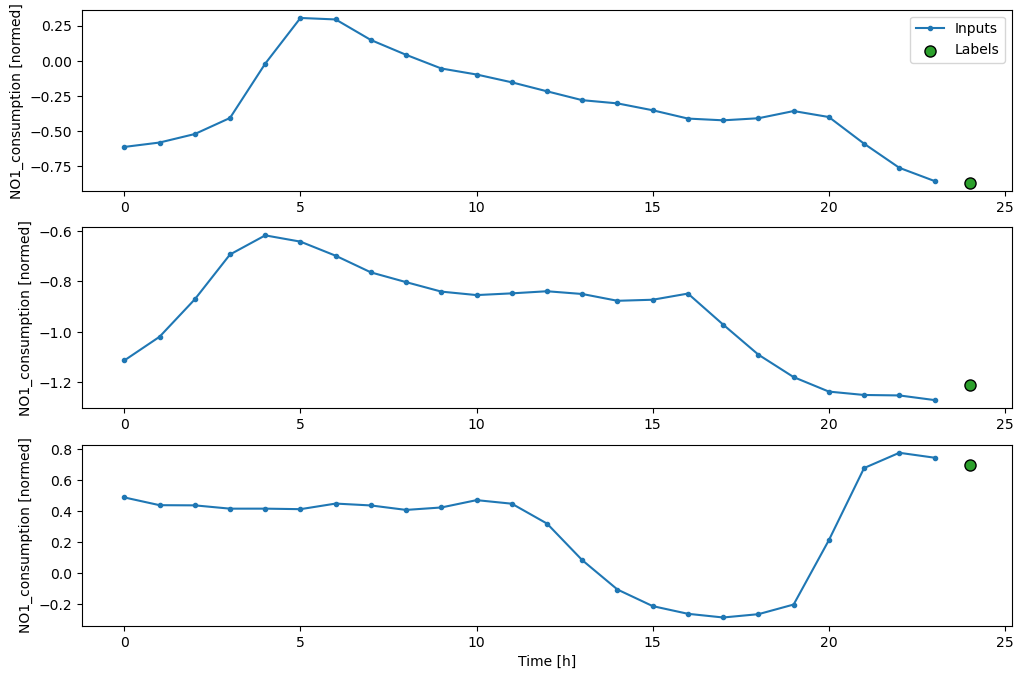

In [5]:

window.plot()

## Long Short-Term Memory model (LSTM)
#### Single-step

In [6]:
wide_window = WindowGenerator(  input_width=24,
                                label_width=24,
                                shift=1,
                                train_df=train_df,
                                val_df=val_df,
                                test_df=test_df,
                                label_columns=['NO1_consumption'])
wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['NO1_consumption']

In [7]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1)
])

val_performance = {}
performance = {}

print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 9)
Output shape: (32, 24, 1)


In [8]:
# history = WindowGenerator.compile_and_fit(lstm_model, wide_window)
# IPython.display.clear_output()
# lstm_model.save('./models/lstm_single_step.keras')
# pickle.dump(window, open('./models/lstm_single_step_history.pkl', 'wb'))


In [9]:
# Load
lstm_model = tf.keras.models.load_model('./models/lstm_single_step.keras')
history = pickle.load(open('./models/lstm_single_step_history.pkl', 'rb'))

In [10]:
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

274/274 [==============================] - 1s 1ms/step - loss: 0.0019 - mean_absolute_error: 0.0331


In [11]:
test_window = tf.stack([np.array(test_df[:wide_window.total_window_size]),
                        np.array(test_df[100:100+wide_window.total_window_size]),
                        np.array(test_df[200:200+wide_window.total_window_size])])

test_inputs, test_labels = wide_window.split_window(test_window)

print('Test input shape:', test_inputs.shape)
print('Test label shape:', test_labels.shape)

Test input shape: (3, 24, 9)
Test label shape: (3, 24, 1)


In [12]:
# Plot training and validation loss
# history_dict = history.history
# loss = history_dict['loss']
# val_loss = history_dict['val_loss']

# epochs = range(1, len(loss) + 1)

# plt.figure()
# plt.plot(epochs, loss, 'b', label='Training loss')
# plt.plot(epochs, val_loss, 'r', label='Validation loss')
# plt.title('Training and validation loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

/Users/mathiasotnes/Desktop/Power-consumption-forecast/utils.py:79: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mean = scalar['mean'][plot_col_index]
/Users/mathiasotnes/Desktop/Power-consumption-forecast/utils.py:80: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  std = scalar['std'][plot_col_index]


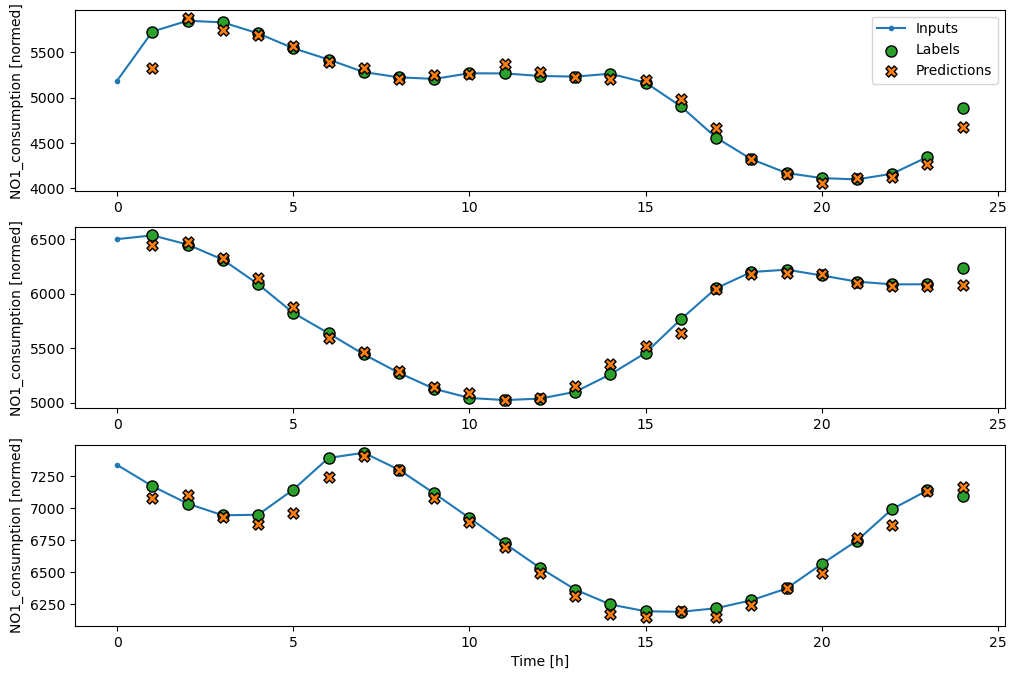

In [13]:
# Plot
wide_window.plot(model=lstm_model, denormalize=True)

## Long Short-Term Memory model (LSTM)
#### Multi-step

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): ['NO1_consumption']

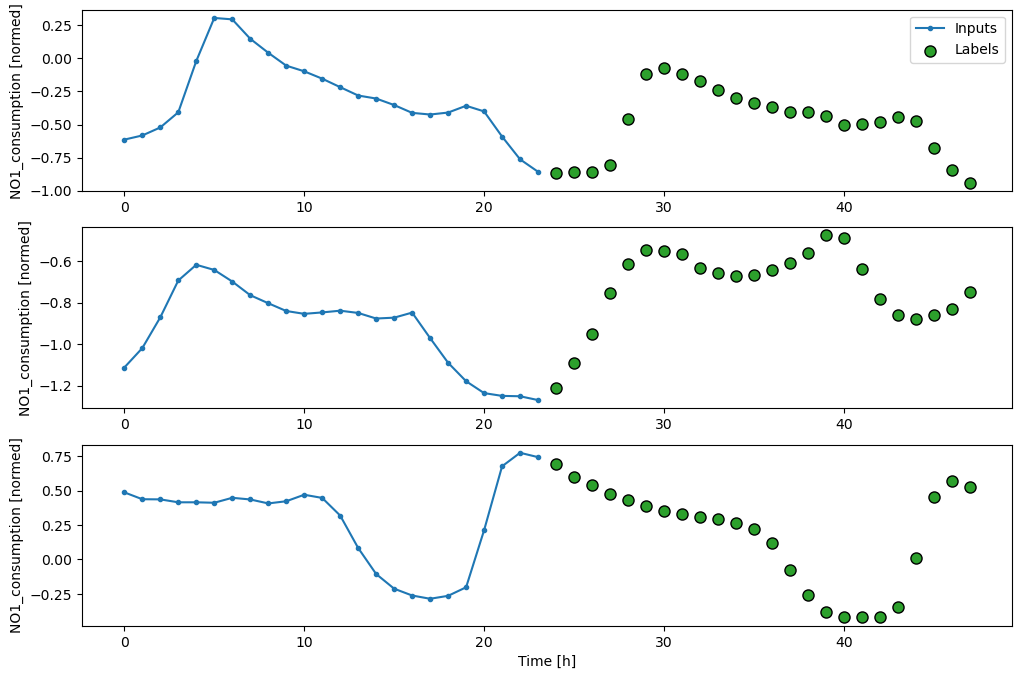

In [14]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               label_columns=['NO1_consumption'])

example_window = tf.stack([np.array(train_df[:multi_window.total_window_size]),
                           np.array(train_df[100:100+multi_window.total_window_size]),
                           np.array(train_df[200:200+multi_window.total_window_size])])

example_inputs, example_labels = multi_window.split_window(example_window)
multi_window.example = example_inputs, example_labels
multi_window.plot()
multi_window

In [15]:
multi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(OUT_STEPS,kernel_initializer=tf.initializers.zeros()),
])


In [16]:
history = WindowGenerator.compile_and_fit(multi_lstm_model, multi_window)
IPython.display.clear_output()
multi_lstm_model.save('./models/lstm_multi_step.keras')
pickle.dump(history, open('./models/lstm_multi_step_history.pkl', 'wb'))

In [17]:
# Load
multi_lstm_model = tf.keras.models.load_model('./models/lstm_multi_step.keras')
history = pickle.load(open('./models/lstm_multi_step_history.pkl', 'rb'))

In [18]:
multi_val_performance = {}
multi_performance = {}

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)

273/273 [==============================] - 1s 2ms/step - loss: 0.0217 - mean_absolute_error: 0.1076


/Users/mathiasotnes/Desktop/Power-consumption-forecast/utils.py:79: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mean = scalar['mean'][plot_col_index]
/Users/mathiasotnes/Desktop/Power-consumption-forecast/utils.py:80: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  std = scalar['std'][plot_col_index]


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

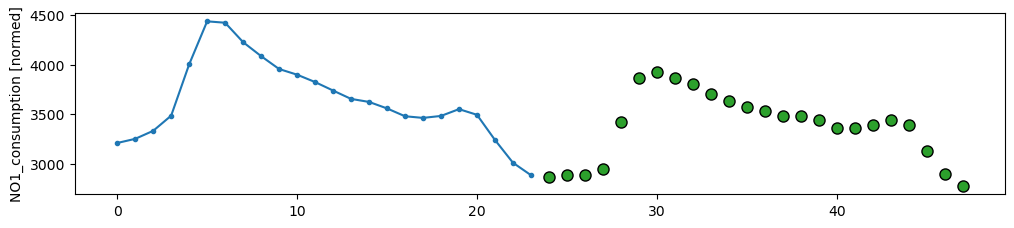

In [19]:
multi_window.plot(multi_lstm_model, denormalize=True)

# Multi-step prediction on bidding area NO2

In [ ]:
features = ['NO2_consumption', 
            'NO2_temperature', 
            'time_of_day', 
            'time_of_week', 
            'time_of_year', 
            'NO2_consumption_lag_24', 
            'NO2_temperature_lag_24', 
            'NO2_consumption_mean_24', 
            'NO2_temperature_mean_24']

test_df = pd.read_csv('./data/test.csv')[features]
val_df = pd.read_csv('./data/val.csv')[features]
train_df = pd.read_csv('./data/train.csv')[features]

multi_window_no2 = WindowGenerator( input_width=24,
                                label_width=OUT_STEPS,
                                shift=OUT_STEPS,
                                label_columns=['NO2_consumption'],
                                train_df=train_df,
                                val_df=val_df,
                                test_df=test_df)

In [ ]:
example_window = tf.stack([np.array(test_df[:multi_window_no2.total_window_size]),
                            np.array(test_df[100:100+multi_window_no2.total_window_size]),
                            np.array(test_df[200:200+multi_window_no2.total_window_size])])

multi_window_no2.example = multi_window_no2.split_window(example_window)

multi_window_no2.plot(multi_lstm_model, plot_col='NO2_consumption', denormalize=True)

### Comparing with model trained on NO2

In [ ]:

multi_lstm_model_no2 = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(OUT_STEPS,kernel_initializer=tf.initializers.zeros()),
])


history = WindowGenerator.compile_and_fit(multi_lstm_model_no2, multi_window_no2)
IPython.display.clear_output()
multi_lstm_model_no2.save('./models/lstm_multi_step_no2.keras')
pickle.dump(history, open('./models/lstm_multi_step_no2_history.pkl', 'wb'))

In [ ]:
# Load
multi_lstm_model_no2 = tf.keras.models.load_model('./models/lstm_multi_step_no2.keras')
history = pickle.load(open('./models/lstm_multi_step_history.pkl', 'rb'))

In [ ]:
pred_no1 = multi_lstm_model.predict(multi_window_no2.test)
pred_no2 = multi_lstm_model_no2.predict(multi_window_no2.test)
pred_no1 = multi_window_no2.denormalize(pred_no1)
pred_no2 = multi_window_no2.denormalize(pred_no2)

In [ ]:
print(pred_no1.shape)
pred_no2.shape

## Convolutional Neural Network (CNN) 

#### n-in-1-out

In [ ]:
features = ['NO1_consumption',
            'NO1_temperature',
            'time_of_day',
            'time_of_week',
            'time_of_year',
            'NO1_consumption_lag_24',
            'NO1_temperature_lag_24',
            'NO1_consumption_mean_24',
            'NO1_temperature_mean_24']

train_df = pd.read_csv('./data/train.csv')[features]
val_df = pd.read_csv('./data/val.csv')[features]
test_df = pd.read_csv('./data/test.csv')[features]

window = WindowGenerator(   input_width=24,
                            label_width=1,
                            shift=1,
                            label_columns=['NO1_consumption'])